# ラベル別予測
- 別々のアンサーデータをラベルとしてそれぞれで予測
- それぞれで重要な変数を見てみる

In [51]:
import time

import pandas as pd
import numpy as np
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn.utils import resample
from sklearn.model_selection import train_test_split

# 自作関数
from dataload.data_load import data_load
from func.my_func import *

In [52]:
keio_df = pd.read_csv('../../../野球部データ収集/keio_data/keio.csv', parse_dates=[1])
use_feature_df = keio_df[['UserID', 'TargetDate', 'Score', 'DiffRestHrValue', 'DiffWakedHrValue',
        'StressCount', 'DeepSleepRate', 'LowActivityHourws']]

answer_df = pd.read_csv('../../../野球部データ収集/keio_data/keio_answer_data.csv', parse_dates=[1])
category = pd.read_csv('../../../野球部データ収集/keio_data/category.csv', encoding='shift-jis')
answer_df = answer_df.merge(category)

def create_user_feature(user_id):
    output_df = use_feature_df[use_feature_df['UserID'] == user_id].reset_index(drop=True)
    output_df['TargetDate'] = output_df['TargetDate'].dt.date
    return output_df

def create_y(user_id):
    _piv_df = answer_df[answer_df['UserID'] == user_id].pivot_table(
        values='value',
        index='TargetDate',
        columns='category'
    ).reset_index()
    _piv_df['TargetDate'] = _piv_df['TargetDate'].dt.date
    _piv_df = _piv_df.drop(['体温', '朝食'], axis=1)
    for i in ['下肢の状態',	'肘の状態', '肩の状態']:
        _piv_df[f'y_{i}'] = _piv_df[i].apply(lambda x: int(x > 2))
    return _piv_df


In [53]:
# users = keio_df['UserID'].unique()
users = [
    # 1504, 
    1505, 
    1755, 
    1781, 
    1774, 
    1773
]
# user_id = users[0]

In [54]:
target_columns = ['下肢の状態',	'肘の状態', '肩の状態']
target_clm = target_columns[0]

In [55]:
def exp(target_clm):

    from sklearn.preprocessing import StandardScaler

    score_df = pd.DataFrame(index=users, columns=['mean'])
    weight_df_dict = {}

    for user_id in users:
        weight_df = pd.DataFrame(columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                    'DeepSleepRate', 'LowActivityHourws'])
        print(user_id)
        _X = create_user_feature(user_id).drop(['UserID', 'Score'], axis=1)
        _y = create_y(user_id)
        df = pd.merge(_X, _y, how='inner', on='TargetDate')
        _X = df[['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount',
                    'DeepSleepRate', 'LowActivityHourws']]
        _X = _X.fillna(_X.mean())
        for n in range(7, len(df)):
            X = _X.iloc[:n]
            y = _y[f'y_{target_clm}'].iloc[:n]
            X_test = _X.iloc[[n]]
            # 正常データのみを使用して標準化
            scaler = StandardScaler()
            if len(X[y == 0]) > 3:
                scaler.fit(X[y == 0])
                normal_Z = scaler.transform(X[y == 0])
                if len(X[y == 1]) > 0:
                    anomaly_Z = scaler.transform(X[y == 1])    # 正常データのみを使用して共分散行列を計算
                inv_C = inv_cov(normal_Z)
                # 異常データと直交表を用いてSN比を計算
                #L8直行表
                l8 = np.array([
                    [1,1,1,1,1,1,1],
                    [1,1,1,2,2,2,2],
                    [1,2,2,1,1,2,2],
                    [1,2,2,2,2,1,1],
                    [2,1,2,1,2,1,2],
                    [2,1,2,2,1,2,1],
                    [2,2,1,1,2,2,1],
                    [2,2,1,2,1,1,2]
                    ])
                l8 = (l8 == 1)
                l8 = l8[:, :len(X.columns)]

                if len(X[y == 1]) > 0:
                    #異常データのマハラノビス距離
                    result = np.zeros((l8.shape[0], anomaly_Z.shape[0]))
                    for i, l8_row in enumerate(l8):
                        result[i] = cal_MD(anomaly_Z[:, l8_row], inv_C[l8_row][:,l8_row])

                    #SN比
                    sn = np.zeros(l8.shape[0])
                    for idx, row in enumerate(result):
                        sum_MD = 0
                        for i in range(len(row)):
                            sum_MD += 1 / row[i]
                        sn[idx] = -10 * math.log10(sum_MD / len(row))
                        
                    # SN比を利用し，不要と思われる変数を削除する
                    # 変数選択
                    df_gain = pd.DataFrame(index=X.columns, columns=['効果ゲイン','残す'])
                    for i, clm in enumerate(X.columns):
                        gain = sum(sn[l8.T[i]]) - sum(sn[~l8.T[i]])
                        df_gain.loc[df_gain.index == clm, '効果ゲイン'] = gain
                        df_gain.loc[df_gain.index == clm, '残す'] = gain > 0
                    # 選択された変数を保存
                    select_columns = X.columns
                    
                    select_gain = df_gain['効果ゲイン'].values
                    
                    select_columns_weight = (select_gain - select_gain.min()) / (select_gain.max() - select_gain.min())
                    # 選択変数でのスケーラーと共分散行列を計算
                    result_scaler = StandardScaler()
                    result_scaler.fit(X[select_columns][y == 0])
                    result_Z = result_scaler.transform(X[select_columns][y == 0])
                    result_inv_C = inv_cov(result_Z)
                    
                    proba, _ = predict_WMTS(X_test, result_scaler, result_inv_C, select_columns, select_columns_weight, threshold=0)
                    df.loc[n, 'pred'] = list(proba)[0]
                    weight_df = weight_df.append(pd.Series(data=select_columns_weight, index=select_columns), ignore_index=True)
                    
                else:
                    result_scaler = scaler
                    result_inv_C = inv_C
                    select_columns = X.columns
                    df.loc[n, 'pred'] = list(predict_MD(X_test, result_scaler, result_inv_C, select_columns))[0]
            else:
                scaler.fit(X)
                Z = scaler.transform(X)
                inv_C = inv_cov(Z)
                _Z = scaler.transform(X_test)
                md = np.dot(_Z, inv_C)
                MD = np.dot(md, _Z.T) / _Z.shape[1]
                df.loc[n, 'pred'] = MD[0][0]
        scaler = StandardScaler()
        plt.plot(scaler.fit_transform(df[['pred', target_clm]].iloc[7:]))
        plt.legend(['pred', target_clm])
        plt.show()
        score_df.loc[user_id] = df[['pred', target_clm]].iloc[7:].corr().iloc[0][1]
        weight_df_dict[user_id] = weight_df
    # 予測精度，相関係数を表示
    display(score_df)
    print(score_df.mean())
    # 変数重要度を表示
    all_user_mean_weight_df = pd.DataFrame(index=users, columns=['DiffRestHrValue', 'DiffWakedHrValue', 'StressCount', 'DeepSleepRate', 'LowActivityHourws'])
    for user_id in users:
        all_user_mean_weight_df.loc[user_id] = weight_df_dict[user_id].mean()
    all_user_mean_weight_df.loc['mean'] = all_user_mean_weight_df.mean()
    display(all_user_mean_weight_df)
    sns.heatmap(all_user_mean_weight_df.astype(float), annot=True, cmap='coolwarm')
    plt.show()
    display(all_user_mean_weight_df.agg(['mean', 'std']).T)

1505


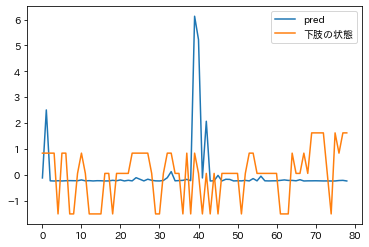

1755


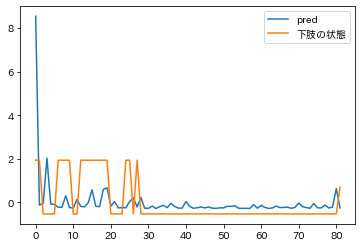

1781


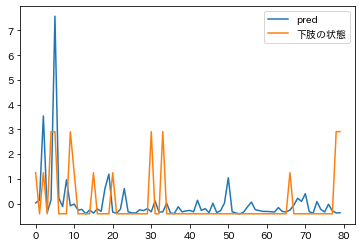

1774


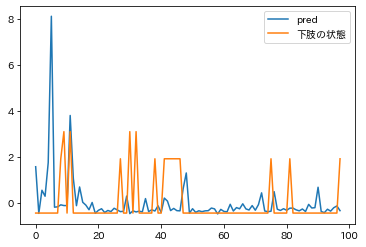

1773


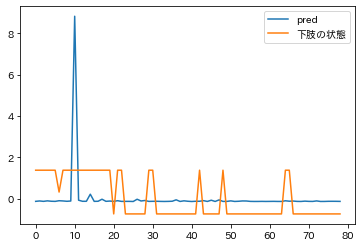

,mean
1505,0.103452
1755,0.258877
1781,0.310579
1774,0.040083
1773,0.163793


mean    0.175357
dtype: float64


,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate,LowActivityHourws
1505,0.056572,0.362872,0.837762,0.847308,0.648026
1755,0.274878,0.290903,0.513785,0.486505,0.749802
1781,0.719717,0.328577,0.18755,0.896127,0.475645
1774,0.181384,0.664859,0.720937,0.434108,0.75222
1773,0.182397,0.809877,0.573138,0.961322,0.636703
mean,0.28299,0.491418,0.566635,0.725074,0.652479


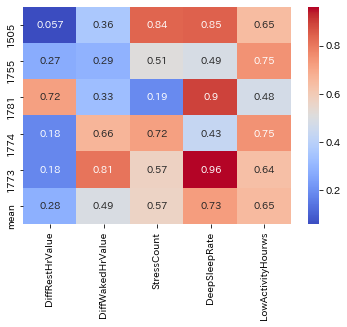

,mean,std
DiffRestHrValue,0.282990,0.229130
DiffWakedHrValue,0.491418,0.207242
StressCount,0.566635,0.220844
DeepSleepRate,0.725074,0.219813
LowActivityHourws,0.652479,0.100954


In [56]:
exp('下肢の状態')

### 下肢の状態考察
- 全アンサーデータの相関係数よりは低いが全期間の相関係数が0.1753
- 全アンサーデータの変数重要度とは異なり，DeepSleepRateの重要度がLowActivityHoursよりも大きくなった．下肢の状態が悪いと深い睡眠がいつものようにできなくなる可能性がある．
- StressCountもuser1781以外は高い値．心拍変動と下肢の状態には関係があるか？

1505


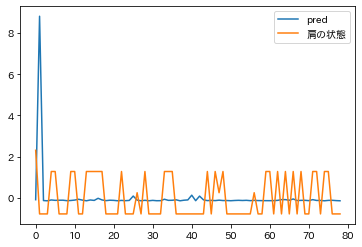

1755


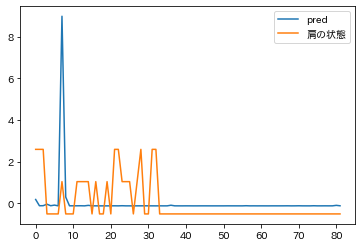

1781


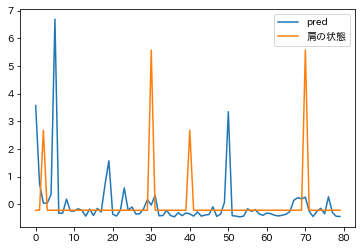

1774


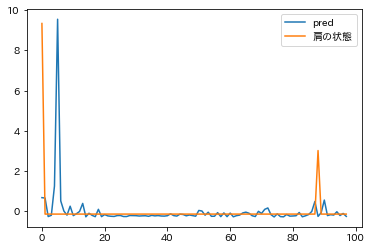

1773


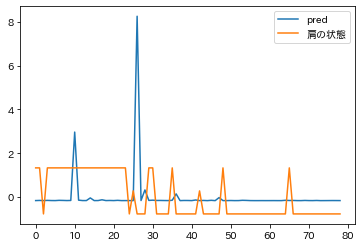

,mean
1505,-0.088753
1755,0.122211
1781,0.005121
1774,0.058699
1773,-0.034882


mean    0.012479
dtype: float64


,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate,LowActivityHourws
1505,0.342535,0.517506,0.468712,0.465657,0.747903
1755,0.528038,0.107756,0.881832,0.096859,0.446685
1781,0.980832,0.125283,0.066284,0.556981,0.139324
1774,0.74628,0.190237,0.236853,0.86429,0.150437
1773,0.358867,0.879951,0.555173,0.61645,0.754873
mean,0.59131,0.364147,0.441771,0.520047,0.447844


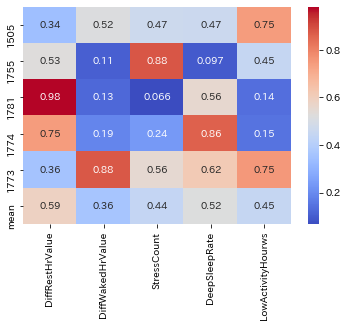

,mean,std
DiffRestHrValue,0.591310,0.243173
DiffWakedHrValue,0.364147,0.297527
StressCount,0.441771,0.279364
DeepSleepRate,0.520047,0.249482
LowActivityHourws,0.447844,0.271271


In [57]:
exp('肩の状態')

### 肩の状態考察
- 全体の相関係数が0.0125と非常に低い，ランダムに予測するのと変わらないような結果．予測に意味がない．予測するにはもっと情報が必要か？もしくは，肩の状態は生体データには現れにくいのでは？
- 予測できていないため何とも言えないが，変数の重要度を見ると選手によって大きく異なることがわかる．

1505


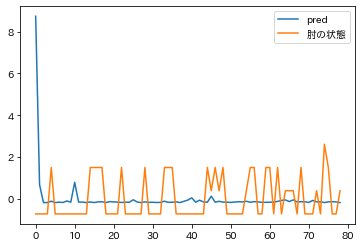

1755


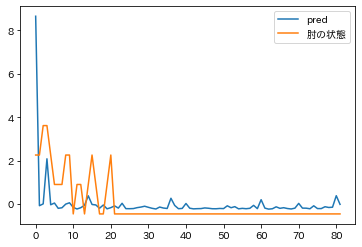

1781


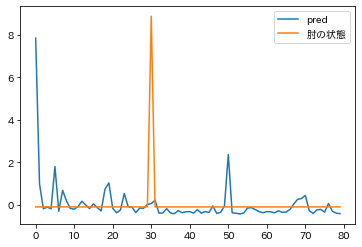

1774


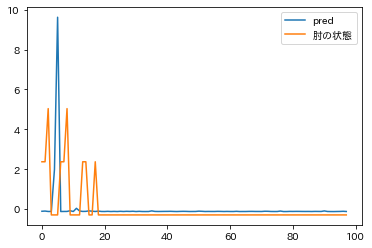

1773


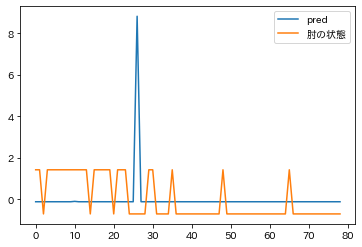

,mean
1505,-0.097979
1755,0.369343
1781,0.004643
1774,-0.036763
1773,-0.078952


mean    0.032059
dtype: float64


,DiffRestHrValue,DiffWakedHrValue,StressCount,DeepSleepRate,LowActivityHourws
1505,0.333035,0.744909,0.433275,0.635818,0.645424
1755,0.681117,0.089572,0.846455,0.330013,0.741306
1781,1.0,0.352185,0.013397,0.60572,0.165022
1774,0.040205,0.651883,0.184279,0.603742,0.857742
1773,0.0,0.998936,0.84146,0.898655,0.846799
mean,0.410871,0.567497,0.463773,0.61479,0.651259


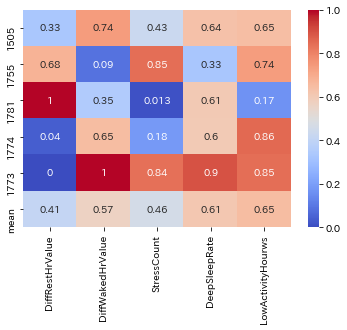

,mean,std
DiffRestHrValue,0.410871,0.382720
DiffWakedHrValue,0.567497,0.316072
StressCount,0.463773,0.337929
DeepSleepRate,0.614790,0.180180
LowActivityHourws,0.651259,0.255124


In [58]:
exp('肘の状態')

### 肘の状態考察
- 相関係数が0.0321と非常に低い結果．肩の状態と同じく，十分な予測ができておらず結果に意味がない可能性が高い．
- 肘の状態と同じく，選手によって重要な変数が異なる．

---
## 次やること
- 相関係数が低すぎるので使用する変数を増やす．一日の平均だけでなく，もっと細かいデータなど
    - 例えば，その日の最大血圧とか，変化などにも注目する？
    - 睡眠と歩数のデータも入れる？
- 期間によってどんな結果が出ているか考察する．（データの蓄積によってどのような変化があるのか？）
    - 序盤は精度が低く，改善されていくのか？
    - 変数の重要度はどのように変化していくのか？